# Credit Card Fraud Classificaition using Decision Trees and Random Forest

In [18]:
import os
os.chdir('D:/ML_Projects/CreditCardFraud/') #Set working directory
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, validation_curve, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as mt
from itertools import cycle

from scipy import interp

from imblearn.over_sampling import ADASYN

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

sns.set_style('whitegrid')

%matplotlib inline

In [2]:
# Read credit card fraud data
cc_fraud = pd.read_csv('./Data/creditcard.csv')
print("Number of instances: %d" % cc_fraud.shape[0])
print("Number of features: %d" % cc_fraud.shape[1])
cc_fraud.head()

Number of instances: 284807
Number of features: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
cc_fraud.Class.value_counts()*100/cc_fraud.shape[0]

0    99.827251
1     0.172749
Name: Class, dtype: float64

To deal with high class imbalance, we perform oversampling. The technique used to perform over sampling is discussed in the following section.

## Metrics for model evaluation

We have to keep imbalance in mind when evaluating model performance. An appropriate metric in this case would be an precision and recall, taking into account the class imbalance.

Precision, Recall and F1-score is defined as follows - 

Let,
* K = number of class
* TP = True Positives

Then we can define precision and recall for each class *k* as,
$$ Precision = \frac {\sum(TP_c)}{\sum{PositivePredictions}} $$

$$ Recall = \frac {\sum(TP_c)}{\sum{PositiveInstances}} $$

Therefore we define the f1-score for class *k* which is just the harmonic mean of precision and recall for class *k* as,

$$ f1_k = 2*\frac {precision * recall}{precision + recall} $$

Then the weighted (weights are defined as the total number of instances for each class) average of f1-scores for all classes is given by 

$$ F1_{weighted} = \frac {\sum_{k=1}^{K} {w_k*f1_k}}{\sum_{k=1}^{K} w} $$

where $w_k$ is the total number of instances for class *k*

## Adaptive Synthetic Sampling (ADASYN)
Over-sampling using Adaptive Synthetic Sampling Approach. According to the [ADASYN paper](http://ieeexplore.ieee.org/document/4633969/?part=1), **ADASYN generates synthetic samples that are difficult to classify**, so that our machine learning model is able to learn more about the difficult samples. 

The idea of the algorithm is as follows - 
- Compute the class imbalance ratio 
- Calculate the total number of synthetic samples that need to be generated for the minority class. (G)
- For each of the minority sample, compute **K** nearest neighbours based on the Euclidean distance in the n-dimensional space and calculate the ratio $r_i$ as $$r_i = \frac{\Delta_i}{K}$$
where $\Delta_i$ is the number of samples in the **K** nearest neigbours that belong to the majority class.
- Normalize $r_i$ so that get a density distribution
- Calculate the number of synthetic samples that need to be generated for each of the minority samples
- For each of the minority samples, create synthetic samples in the following manner: $$s_i = x_i +(x_z - x_i)*\lambda$$
    - $x_z$: Randomly selected minority sample
    - $(x_z - x_i)$: Difference between the samples in the n-dimensional space
    - $\lambda$: Random number between $[0,1]$

In [4]:
%%time
pd.options.mode.chained_assignment = None  # default='warn'
ros = ADASYN(n_neighbors = 5, ratio = 'auto', random_state=123, n_jobs = -1)

X = cc_fraud.drop(['Class', 'Time'], axis = 1)
y = cc_fraud['Class']

# X_data = np.array(X_data)
# y_data = np.array(y_data)

# Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 735215)

# Convert amount to standar scaler format
ss_obj = StandardScaler()
X_train['nAmount'] = ss_obj.fit_transform(X_train['Amount'].values.reshape(-1,1))
X_train = X_train.drop(['Amount'], axis=1)

# Fit standard scaler object to test data
X_test['nAmount'] = ss_obj.transform(X_test['Amount'].values.reshape(-1,1))
X_test = X_test.drop(['Amount'], axis=1)

X_ros, y_ros = ros.fit_sample(X_train, y_train)
print('Original data shape: {}'.format(Counter(y_train)))
print('Reshaped data shape: {}'.format(Counter(y_ros)))

Original data shape: Counter({0: 170604, 1: 280})
Reshaped data shape: Counter({1: 170618, 0: 170604})
Wall time: 1h 16min 35s


In [13]:
def plot_val_curve(train_scores, val_scores, param_range, plt_title):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(14,6))
    
    plt.title(plt_title)
    plt.xlabel("$C-Regularization parameter$")
    plt.ylabel("Accuracy")
    
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    
    plt.semilogx(param_range, val_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    
    plt.fill_between(param_range, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")

def plot_learning_curve(X,y,clf_estimator, cv_estimator, scorer, xlabel=''):
    train_x_axis, train_scores, test_scores =learning_curve(estimator=clf_estimator,
                                                           X=X,
                                                           y=y,
                                                           train_sizes=np.linspace(0.1, 1.0, 10),
                                                           cv=cv_estimator,
                                                           scoring=scorer,
                                                           exploit_incremental_learning=False,
                                                           n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_x_axis, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_x_axis,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_x_axis, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_x_axis,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.tight_layout()
    

def plot_confusion_matrix(cm, class_names, title_text='Confusion Matrix', normalize=False):
    plt.figure(figsize=(10,5))
    acc = cm.diagonal().sum()/cm.sum()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names,
               annot_kws={"size":15})
    plt.title(title_text+' Accuracy = {:.4f}'.format(acc), fontsize=20)
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual Class', fontsize=16)
    plt.tick_params(labelsize=14)

In [21]:
# Define stratified k-fold cross validation object

K = 10 #Number of folds for cross validation
stratified_cv = StratifiedShuffleSplit(n_splits = K, random_state = 489567)
class_names = ['Legitimate','Fraud']

In [8]:
param = {'criterion':['gini','entropy'],
         'max_features':['log2','auto']}
clf_DT = DecisionTreeClassifier()

grid_DT = GridSearchCV(estimator=clf_DT, param_grid=param,
                     scoring='accuracy', n_jobs=-1,
                     cv = stratified_cv)
grid_DT_scores = grid_DT.fit(X_ros, y_ros)

In [11]:
grid_DT_scores.best_score_

0.9992790786273188

AttributeError: 'NoneType' object has no attribute 'children_left'

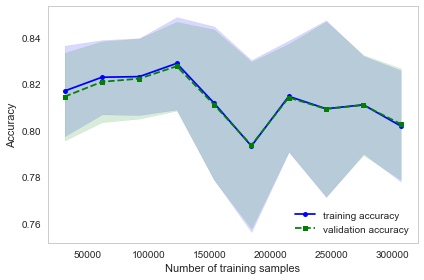

In [22]:
clf_DT = DecisionTreeClassifier(criterion='gini',max_features='auto',
                               max_depth=3)

plot_learning_curve(X_ros, y_ros, clf_DT, stratified_cv,'accuracy',xlabel='Number of training samples')

import pydotplus
from IPython.display import Image
dot_data = export_graphviz(clf_DT, out_file=None,
                           class_names=class_names,
                           filled=True, rounded=True,
                           special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())